In [1]:
import numpy as np
import torch
import networkx as nx
from torchvision import transforms

from src.CBN import CausalBayesianNetwork as CBN
import modularised_utils as mut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import evaluation_utils as evut
import params
import torchvision
import random
import joblib

import opt_utils as oput

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'cmnist'

In [3]:
T_results_emp = joblib.load(f"data/{experiment}/diroca_train_results_empirical.pkl")

In [4]:
#abduction       = False
coeff_estimation = False

Dll_obs, Dhl_obs  = mut.load_samples(experiment)[None][0], mut.load_samples(experiment)[None][1] 
num_llsamples, num_hlsamples = Dll_obs.shape[0], Dhl_obs.shape[0]

Gll, Ill = mut.load_model(experiment, 'LL')
Ghl, Ihl = mut.load_model(experiment, 'HL')

n_varsll, n_varshl = len(Gll.nodes()), len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)

LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels = {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [6]:
LLmodels = joblib.load(f"data/{experiment}/LLmodels.pkl")
HLmodels = joblib.load(f"data/{experiment}/HLmodels.pkl")

AttributeError: Can't get attribute 'CMNISTLinearSCM' on <module '__main__'>

In [16]:
def generate_empirical_data(LLmodels, HLmodels, omega, U_L, U_H):
    Ill = list(LLmodels.keys())
    Ihl = list(HLmodels.keys())
   
    dbase = {}
    for iota in Ill:
        print(U_L.shape)
        print(LLmodels[iota].F.shape)
        dbase[iota] = U_L @ LLmodels[iota].F

    dabst = {}
    for eta in Ihl:
        dabst[eta] = U_H @ HLmodels[eta].F

    data = {}
    for iota in Ill:
        data[iota] = (dbase[iota], dabst[omega[iota]])

    return data

In [17]:
data = generate_empirical_data(LLmodels, HLmodels, omega, U_ll_hat, U_hl_hat)

(1000, 3092)
(3, 3)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 3092)

In [36]:
test_observ        = True
test_interv        = True 
metric             = 'fro'
num_iter           = 20

if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

In [37]:
rad_values = np.arange(0.05, 10.05, 3).tolist()  
#rad_values = [0.05, 1, 2,3, 4, 5, 10, 50]
sample_forms = ['boundary']

In [38]:
hat_dict = {'L': U_ll, 'H': U_hl}

In [39]:
worst = 'T_8'

In [40]:
T_results_emp = diroca_train_results_empirical

In [41]:
U_worst_L = T_results_emp[worst]['optimization_params']['L']['pert_U']
U_worst_H = T_results_emp[worst]['optimization_params']['H']['pert_U']


In [42]:
worst_dict = {'L': U_worst_L, 'H': U_worst_H}

In [43]:
center = 'hat'
if center == 'hat':
    center_matrix = hat_dict
elif center == 'worst':
    center_matrix = worst_dict

In [44]:
# First run the Abs-LiNGAM algorithm to get the transformation matrices
abslingam_results = evut.run_abs_lingam_complete(data_observational_ll, data_observational_hl)

# Add these results to your T_results_emp dictionary
T_results_emp['T_pa'] = {'optimization_params':{'L':{'pert_U':U_ll},'H':{'pert_U':U_hl}}, 'T_matrix': abslingam_results['Perfect']['T'].T}
T_results_emp['T_na'] = {'optimization_params':{'L':{'pert_U':U_ll},'H':{'pert_U':U_hl}}, 'T_matrix': abslingam_results['Noisy']['T'].T}

In [45]:
# Initialize results structure
results = {rad: {
    sample_form: {
        'empirical': {method: [] for method in T_results_emp.keys()}
    } for sample_form in sample_forms
} for rad in rad_values}

for rad in tqdm(rad_values):
    print(f"Radius: {rad}")
    for sample_form in sample_forms:
        print(f"Sample form: {sample_form}")
        for iter_num in range(1):
            print(f"Iteration: {iter_num}")
            pert_L = evut.generate_perturbation_matrix(rad, sample_form, 'L', hat_dict)
            pert_H = evut.generate_perturbation_matrix(rad, sample_form, 'H', hat_dict)
            
            for name, method_data in T_results_emp.items():
                print(f"Method: {name}")
                T = method_data['T_matrix']
                    
                # total = 0
                # for iota in test_data.keys():

                #     base, abst = test_data[iota]
                    
                #     # Apply perturbations
                #     base_pert = base + pert_L
                #     abst_pert = abst + pert_H
                    
                #     # Normalize
                #     base_norm = base_pert / np.linalg.norm(base_pert, 'fro')
                #     abst_norm = abst_pert / np.linalg.norm(abst_pert, 'fro')
                    
                #     # Apply method and compute distance
                #     tau_base = base_norm @ T.T
                #     dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                #     total += dist
                total = 0
                for iota in Ill_relevant:
                    print(f"Iota: {iota}")
                    L_i = LLmodels[iota].F
                    H_i = HLmodels[omega[iota]].F
                   
                    D_l = L_i @ (center_matrix['L'].T + pert_L.T)
                    D_h = H_i @ (center_matrix['H'].T + pert_H.T)
                    
                    # Normalize
                    base_norm = D_l / np.linalg.norm(D_l, 'fro')
                    abst_norm = D_h / np.linalg.norm(D_h, 'fro')
                    
                    tau_base = T @ base_norm
                    dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                    total += dist
                
                # Store average error for this iteration
                iter_avg = total / len(Ill_relevant)
                results[rad][sample_form]['empirical'][name].append(iter_avg)

# Print results
print("\n" + "="*100)
print(f"{'Radius':<8} {'Sample Form':<12} {'Method':<15} {'Error (mean ± CI)':<35}")
print("="*100)

for rad in rad_values:
    for sample_form in sample_forms:
        print(f"\nRadius: {rad}, Sample form: {sample_form}")
        print("-"*100)
        
        for method in T_results_emp.keys():
            # Compute statistics
            errors = results[rad][sample_form]['empirical'][method]
            error_mean = np.mean(errors)
            error_std = np.std(errors)
            ci = 1.96 * error_std  # 95% confidence interval
            
            # Print row
            print(f"{rad:<8} {sample_form:<12} {method:<15} "
                    f"{error_mean:>8.4f} ± {ci:<8.4f}")

# Find best methods
for rad in rad_values:
    for sample_form in sample_forms:
        print(f"\nBest method for radius {rad}, {sample_form} sampling:")
        
        error_means = {method: np.mean(results[rad][sample_form]['empirical'][method])
                        for method in T_results_emp.keys()}
        best_method = min(error_means.items(), key=lambda x: x[1])
        
        print(f"Best method: {best_method[0]} (error: {best_method[1]:.4f})")
    

  0%|          | 0/4 [00:00<?, ?it/s]

Radius: 0.05
Sample form: boundary
Iteration: 0


TypeError: generate_perturbation_matrix() missing 1 required positional argument: 'coverage'

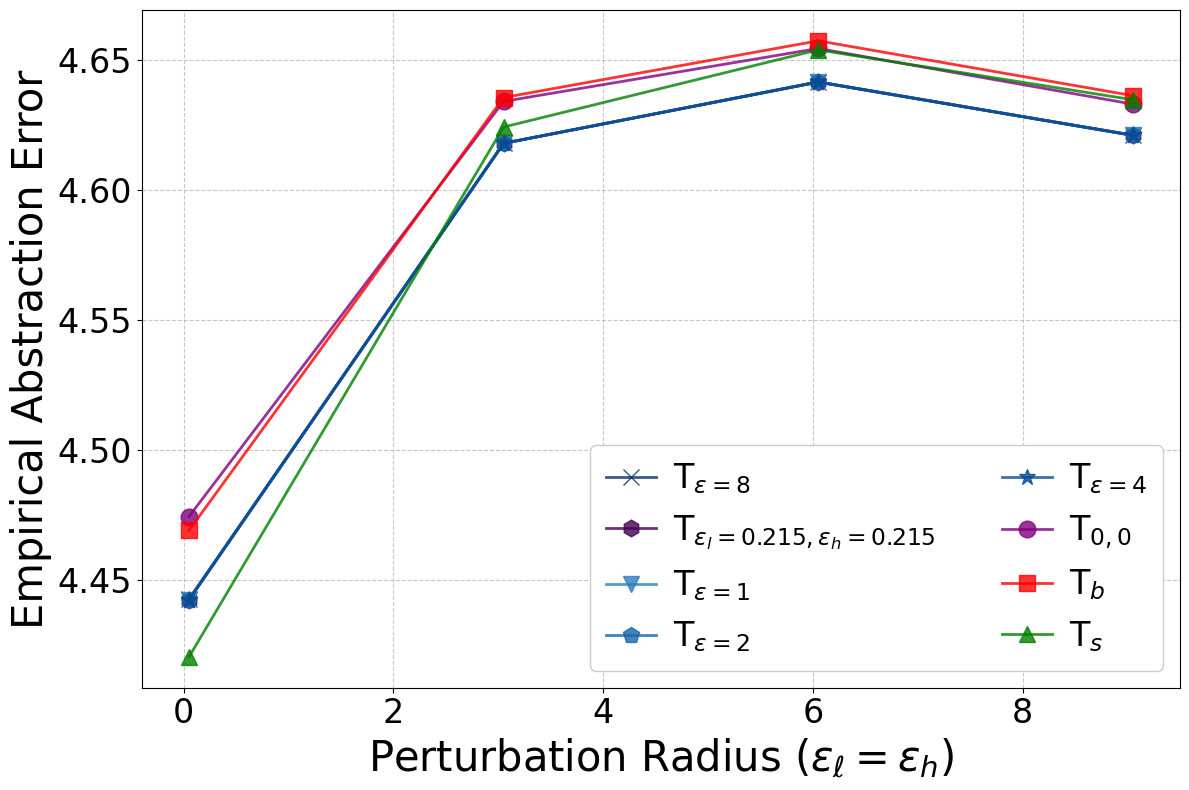

In [89]:
# Example usage with epsilon-delta methods
methods_to_plot = list(T_results_emp.keys())
evut.plot_empirical_abstraction_error(results, methods_to_plot, 'boundary')
# evut.plot_empirical_abstraction_error(results, methods_to_plot, 'sample')

In [92]:
# Initialize results structure
results_random = {method: [] for method in T_results_emp.keys()}

#for pert_L, pert_H in tqdm(zip(pert_family_L, pert_family_H)):
for i in tqdm(range(2)):
    rad = random.uniform(0.05, 10.05)
    sample_form = random.choice(['boundary', 'sample'])
    pert_L = evut.generate_perturbation_matrix(rad, sample_form, 'L', hat_dict).T
    pert_H = evut.generate_perturbation_matrix(rad, sample_form, 'H', hat_dict).T
    for name, method_data in T_results_emp.items():
        T = method_data['T_matrix']
            
        total = 0
        for iota in Ill_relevant:
            L_i = LLmodels[iota].F
            H_i = HLmodels[omega[iota]].F
            
            D_l = L_i @ (center_matrix['L'].T + pert_L)
            D_h = H_i @ (center_matrix['H'].T + pert_H)
            
            # Normalize
            base_norm = D_l / np.linalg.norm(D_l, 'fro')
            abst_norm = D_h / np.linalg.norm(D_h, 'fro')
            
            tau_base = T @ base_norm
            dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
            total += dist
        
        # Store average error for this iteration
        iter_avg = total / len(Ill_relevant)  # Changed from len(Ill) to len(test_data.keys())
        results_random[name].append(iter_avg)

100%|██████████| 2/2 [01:00<00:00, 30.24s/it]


In [93]:
# Print results with ranking
print("\n" + "="*100)
print(f"{'Rank':<5} {'Method':<15} {'Empirical Distance (mean ± CI)':<35}")
print("="*100)

for sample_form in sample_forms:
    print(f"\nSample form: {sample_form}")
    print("-"*100)
    
    # Calculate means for all methods
    method_means = {method: np.mean(results_random[method]) 
                   for method in T_results_emp.keys()}
    
    # Sort methods by mean error (worst to best)
    sorted_methods = sorted(method_means.items(), key=lambda x: x[1], reverse=True)
    
    # Print ranked results
    for rank, (method, mean) in enumerate(sorted_methods, 1):
        std = np.std(results_random[method])
        print(f"{rank:<5} {method:<15} "
              f"{mean:>8.4f} ± {1.96*std:<8.4f}")

print("="*100)

# Print summary of best and worst methods
for sample_form in sample_forms:
    print(f"\nSummary for {sample_form} sampling:")
    print("-"*100)
    
    # Get sorted methods
    method_means = {method: np.mean(results_random[method]) 
                   for method in T_results_emp.keys()}
    sorted_methods = sorted(method_means.items(), key=lambda x: x[1], reverse=True)
    
    # Print worst and best
    worst_method, worst_error = sorted_methods[0]
    best_method, best_error = sorted_methods[-1]
    
    print(f"Worst method: {worst_method} (error: {worst_error:.4f})")
    print(f"Best method: {best_method} (error: {best_error:.4f})")
    print(f"Error difference: {worst_error - best_error:.4f}")


Rank  Method          Empirical Distance (mean ± CI)     

Sample form: boundary
----------------------------------------------------------------------------------------------------
1     T_b               4.6264 ± 0.0312  
2     T_0.00            4.6256 ± 0.0282  
3     T_s               4.6119 ± 0.0488  
4     T_2               4.6083 ± 0.0362  
5     T_4               4.6083 ± 0.0362  
6     T_1               4.6083 ± 0.0362  
7     T_0.215-0.215     4.6083 ± 0.0362  
8     T_8               4.6082 ± 0.0361  
9     T_pa              1.0012 ± 0.0010  
10    T_na              1.0009 ± 0.0010  

Summary for boundary sampling:
----------------------------------------------------------------------------------------------------
Worst method: T_b (error: 4.6264)
Best method: T_na (error: 1.0009)
Error difference: 3.6255
